In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [20]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import numpyro
import numpy as np
from numpyro.infer import NUTS, MCMC
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

In [46]:
data = pd.read_table('data/M63/M63_FOV_VIerr.dat', names=['V', 'Verr', 'I', 'Ierr'], delimiter=' ')

# BAD, BAD, BAD!
Vext = 0.043
Iext = 0.027
data['V'] = data['V'] - Vext
data['I'] = data['I'] - Iext

data['V-I'] = data['V'] - data['I']

rgb_mask = (data['V-I'] > 0.6) & (data['V-I'] < 2.5)
data_rgb = data.loc[rgb_mask]

Nfit = 2048
inds = np.random.choice(len(data_rgb), Nfit)
data_cut = data_rgb.iloc[inds]
# data_cut = data

(27.73545, 24.0)

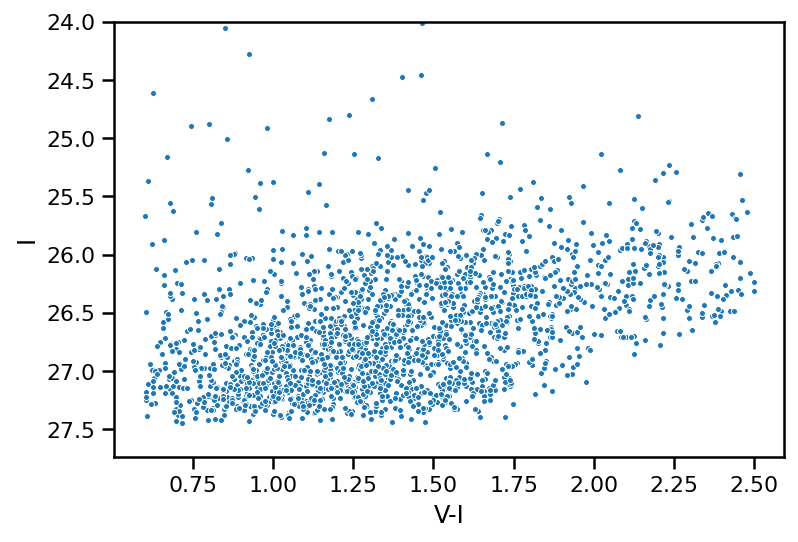

In [48]:
p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.')
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

(29.387, 25.0)

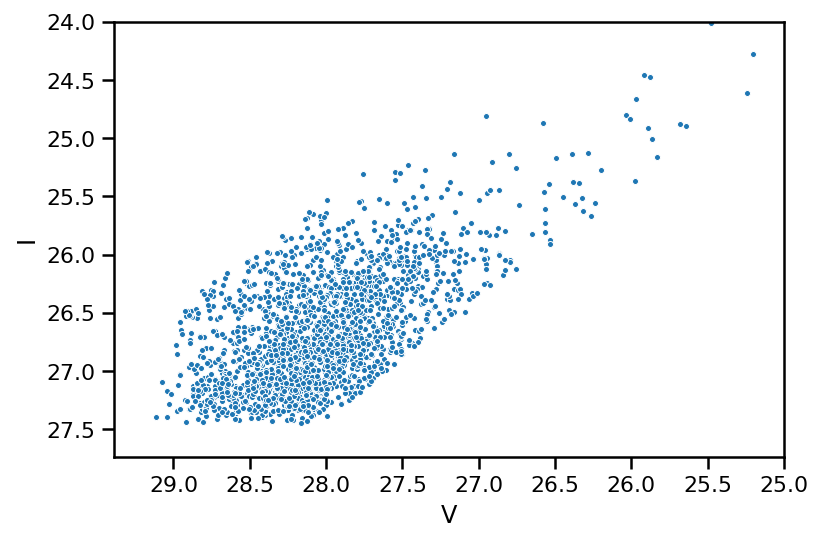

In [49]:
p = sns.scatterplot(data=data_cut, x='V', y='I', marker='.')
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
xl, xh = p.axes.get_xlim()
xl = 25 # Same
p.axes.set_ylim(yh, yl)
p.axes.set_xlim(xh, xl)

In [McQuinn, et al. (2017)](https://iopscience.iop.org/article/10.3847/1538-3881/aa7aad), the metallicity correction is 
$$
A_\mathrm{F814W} = -4.06 + 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right).
$$

Putting this into our language, we have 
$$
A_\mathrm{F814W} - 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right) = -4.06 + \mu
$$
where $\mu$ is the distance modulus.  Thus we see that $c = -0.2$, and the centering parameter for $C = 1.23$, and then $e_\mathrm{centered} = -4.06 + \mu$.

In [36]:
Aobs = np.column_stack((data_cut['I'], data_cut['V']))
sigma_obs = np.column_stack((data_cut['Ierr'], data_cut['Verr']))

c_mu = -0.2
c_sigma = 0.01
c_center = 1.23

e_center = 25.68
e_sigma = 0.1


In [37]:
num_chains=4
thinning=2
sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_chains=num_chains, num_warmup=1000*thinning, num_samples=1000*thinning, thinning=thinning)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, e_center_mu=e_center, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, c_center=c_center)
trace = az.from_numpyro(mcmc)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

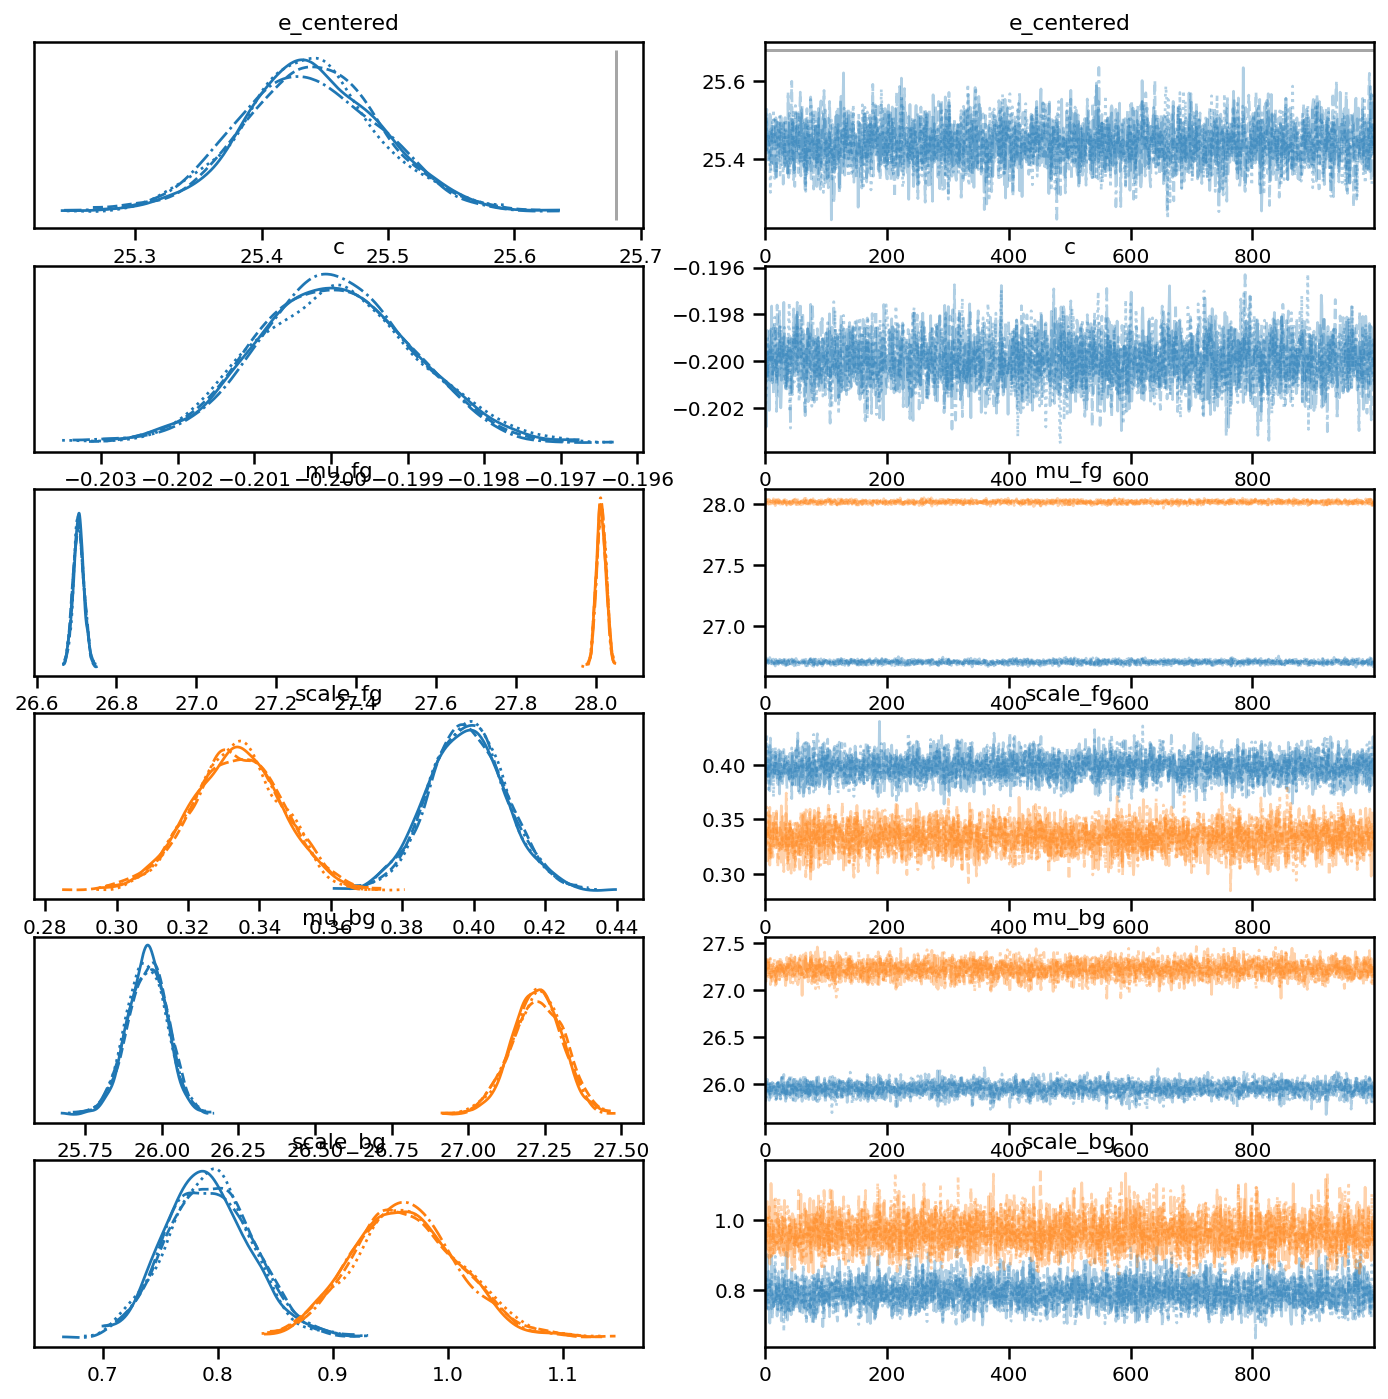

In [38]:
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('e_centered', {}, e_center)])

In [39]:
az.summary(trace, var_names=['e_centered', 'c', 'mu_fg', 'mu_bg', 'cov_fg', 'cov_bg'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e_centered,25.438,0.055,25.332,25.540,0.001,0.001,3210.0,3307.0,1.0
c[0],-0.200,0.001,-0.202,-0.198,0.000,0.000,3006.0,3090.0,1.0
mu_fg[0],26.705,0.013,26.679,26.729,0.000,0.000,3124.0,3234.0,1.0
mu_fg[1],28.014,0.012,27.992,28.035,0.000,0.000,3057.0,2824.0,1.0
mu_bg[0],25.951,0.065,25.825,26.068,0.001,0.001,3060.0,3079.0,1.0
mu_bg[1],27.225,0.082,27.075,27.380,0.002,0.001,2794.0,2777.0,1.0
"cov_fg[0, 0]",0.159,0.008,0.142,0.174,0.000,0.000,2801.0,3139.0,1.0
"cov_fg[0, 1]",0.070,0.006,0.060,0.081,0.000,0.000,2670.0,3024.0,1.0
"cov_fg[1, 0]",0.070,0.006,0.060,0.081,0.000,0.000,2670.0,3024.0,1.0
"cov_fg[1, 1]",0.111,0.008,0.096,0.127,0.000,0.000,3120.0,3314.0,1.0


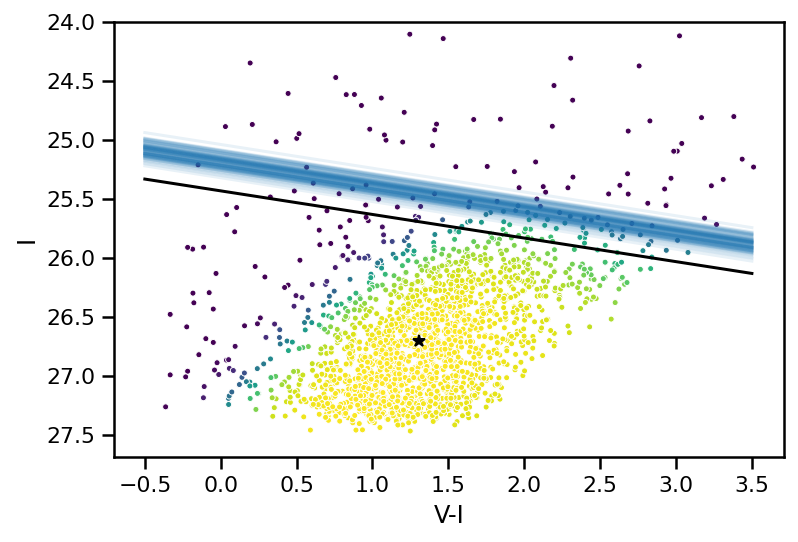

In [42]:
p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.', c=np.exp(trace.posterior.log_fg_prob.mean(axis=(0,1))))
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

vis = np.linspace(-0.5, 3.5, 1024)
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(vis, trace.posterior.e_centered[c,d].values - trace.posterior.c[c,d,0].values*(vis - c_center), color=sns.color_palette()[0], alpha=0.1)
plt.plot(vis, e_center - c_mu*(vis-c_center), color='k')

m = trace.posterior.mu_fg
plt.plot(m[:,:,1].mean()-m[:,:,0].mean(), m[:,:,0].mean(), '*k')

array([<AxesSubplot:title={'center':'e_centered'}>,
       <AxesSubplot:title={'center':'c\n0'}>], dtype=object)

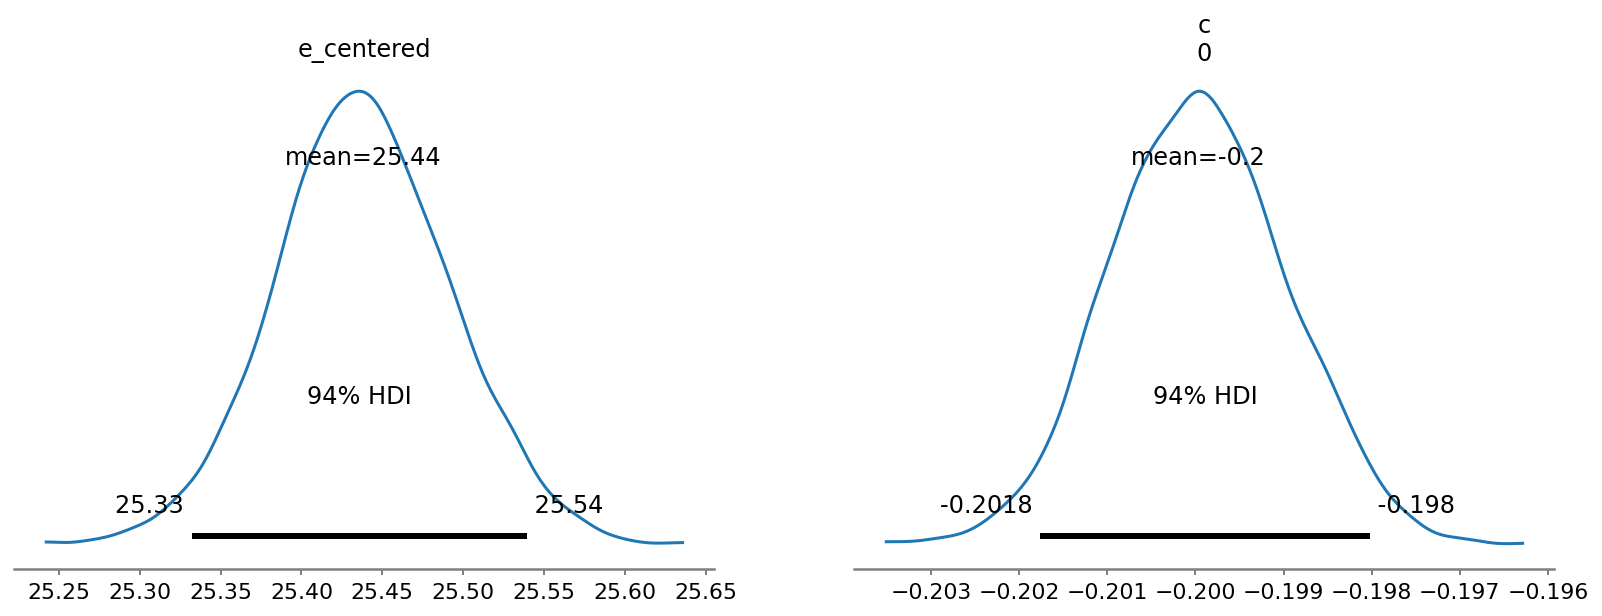

In [43]:
az.plot_posterior(trace, var_names=['e_centered', 'c'], round_to=4)

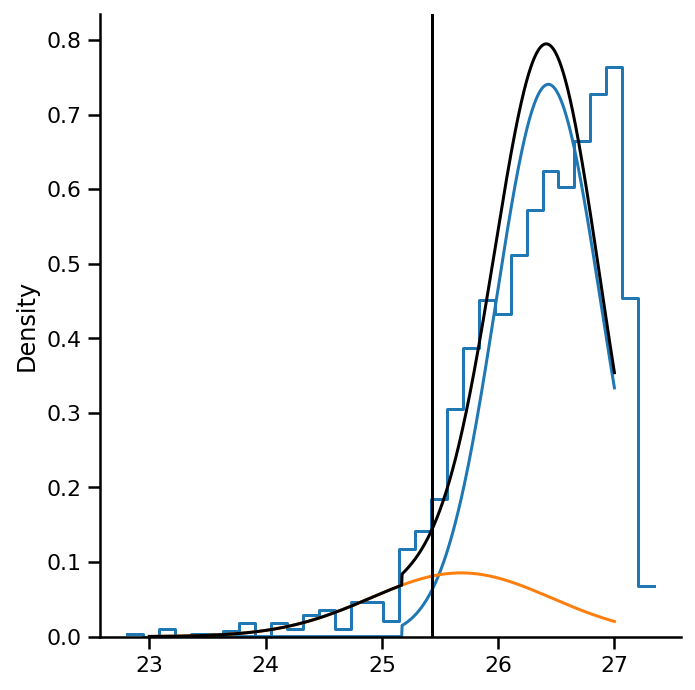

In [44]:
c = np.random.choice(trace.posterior.chain)
d = np.random.choice(trace.posterior.draw)

mu_f = trace.posterior.mu_fg[c,d,:].values
cov_f = trace.posterior.cov_fg[c,d,:,:].values
mu_b = trace.posterior.mu_bg[c,d,:].values
cov_b = trace.posterior.cov_bg[c,d,:,:].values
fb = trace.posterior.f_bg[c,d].values
w = trace.posterior.w[c,d,:].values
e = trace.posterior.e[c,d].values
cc = trace.posterior.c[c,d].values

mu_fe = np.dot(w, mu_f)
sigma_fe = np.sqrt(np.dot(w, np.dot(cov_f, w)))
mu_be = np.dot(w, mu_b)
sigma_be = np.sqrt(np.dot(w, np.dot(cov_b, w)))

Ae = np.dot(Aobs, w)

sns.displot(Ae, stat='density', element='step', fill=False)

Aes = np.linspace(23, 27, 1024)
p_bg = ss.norm(mu_be, sigma_be).pdf(Aes)
d_fg = ss.norm(mu_fe, sigma_fe)
p_fg = d_fg.pdf(Aes)*np.where(Aes > e, 1, 0)/(1-d_fg.cdf(e))
p = fb*p_bg + (1-fb)*p_fg
plt.plot(Aes, (1-fb)*p_fg)
plt.plot(Aes, fb*p_bg)
plt.plot(Aes, p, color='k')
plt.axvline(e_center + c_center*cc, color='k')